In [1]:
import numpy as np
import scipy as scp
import seaborn as sbn
import matplotlib.pyplot as plt
import pickle
import statsmodels as sm

In [2]:
from reliability.Fitters import Fit_Everything

In [3]:
# !pip install github

# Problem specification

$$\mathbb{H} \in \mathbb{R}^{N \times N} $$

$$\mathbb{H}_{ij} \sim \mathcal{N}\left( 0,1 \right) $$
$$\mathbb{H}_{ii} \sim \mathcal{N}\left( 0,2 \right) $$

$$\mathbb{H}^{\mbox{(sym)}} = \frac{\mathbb{H} + \mathbb{H}^{\mbox{T}}}{\sqrt{2}} $$ => GOE

## Defining necesary functions (and testing them)

In [4]:
def generate_H(N: int = 8, seed: int = 13):
    """ return square mtx of given shape (N) """
    #np.random.seed(seed=seed)
    H = np.zeros([N,N])
    for i in range(N):
        for j in range(N):
            if i!=j:
                mu = 0
                sigma = 1
                H[i,j] = mu + sigma * np.random.randn()
            else:
                mu = 0
                sigma = 2
                H[i,i] = mu + sigma * np.random.randn()
    return H

In [5]:
H = generate_H(3)
print(H)

[[ 0.78148668 -1.19097087 -0.694753  ]
 [ 0.0271646   0.77966887 -0.46216582]
 [-0.67465775 -3.18463233  2.6546376 ]]


In [6]:
def symmetrize(H):
    """ symetrizes given matrix """
    return (H+H.T) *(1/np.sqrt(2))

In [7]:
H_sym = symmetrize(H)
print(H_sym)

[[ 1.10518905 -0.8229353  -0.96831963]
 [-0.8229353   1.10261829 -2.5786757 ]
 [-0.96831963 -2.5786757   3.7542245 ]]


In [48]:
def get_eigs(H):
    """returns (ordered) list of eigenvalues of given mtx """
    spectral_analysis = np.linalg.eig(H)
    eig_vals = spectral_analysis[0]
    return eig_vals

In [49]:
get_eigs(H_sym)

array([-1.12999974,  1.7246257 ,  5.36740588])

## experiment

In [10]:
""" define a function 'experiment' that  """
def experiment(name:str = 'none', num_of_dims_of_mtx: int = 3, print_result: bool = False, seed = 13):
    """ single experiment """
    result = []
    K = generate_H(num_of_dims_of_mtx, seed=seed)
    K_sym = symmetrize(K)
    eigs = get_eigs(K_sym)
    result.extend(eigs.tolist())
    if print_result:
        print(result)
    return result

In [11]:
# testing experiment function >>
for _ in range(2):
    experiment(num_of_dims_of_mtx=3, print_result=True)

[6.08093453912971, 0.571417272234179, 1.5142057026905065]
[2.0749004592121714, -0.5613343142269802, -3.1938172227980743]


In [12]:
num_of_experiments = 1000
num_of_dims_of_mtx = 80
results = []
for i in range(num_of_experiments):
    K = generate_H(num_of_dims_of_mtx)
    K_sym = symmetrize(K)
    eigs = get_eigs(K_sym)
    #results.append(eigs)
    results.extend(eigs.tolist())

#print(results)

In [13]:
len(results)

80000

In [14]:
# save current experiment (manual use)
#with open("exp_8mtx_1000_temp3.pk1", "wb") as file:
#    pickle.dump(results, file)

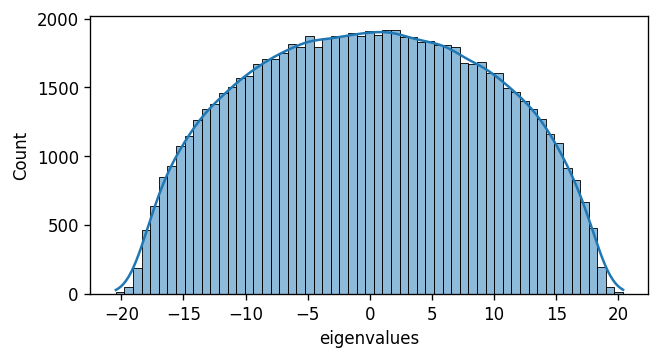

In [15]:
plt.figure(figsize=(6,3), dpi=120)
sbn.histplot(results, kde=True)

plt.xlabel('eigenvalues')
plt.savefig('hist_8_1000_temp3.png', dpi=300)

plt.show()

In [16]:
# vysledky jakz takz pro:
# - N = 80
# - num_of_experiments = 10000 a vice
# - diagonala z N(0,1), nediagonala z N(0,2)

# analysis of result

In [17]:
# is it normal distribution?
# Perform the Shapiro-Wilk test
from scipy.stats import shapiro
statistic, p_value = shapiro(results)

if p_value > 0.05:   # Check if the p-value is less than the significance level
    print("Data looks like it comes from a normal distribution (fail to reject H_0, have to accept H_0)")
else:
    print("Data does not look like it comes from a normal distribution (reject H_0)")

Data does not look like it comes from a normal distribution (reject H0)


/home/bond/.pyenv/versions/3.11.6/lib/python3.11/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [47]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

data = results
data = np.array(data)

mean, std = norm.fit(data, method='mle')

Fit results: mean = -0.005680787171313114,  std = 9.325974179655903


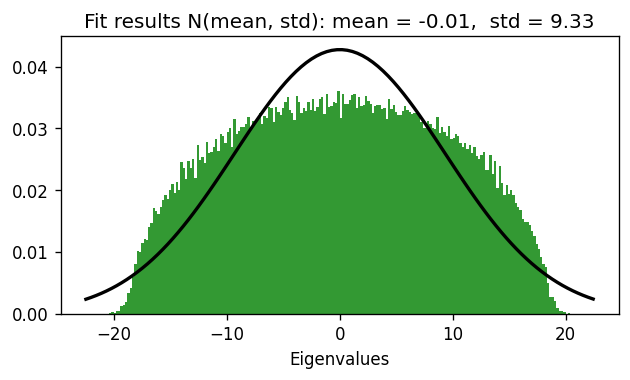

In [46]:
plt.figure(figsize=(6,3), dpi=120)
plt.hist(data, bins=200, density=True, alpha=0.8, color='g')
#sbn.histplot(data, kde=False)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mean, std)

plt.plot(x, p, 'k', linewidth=2)
print(f'Fit results: mean = {mean},  std = {std}')

plt.title("Fit results N(mean, std): mean = %.2f,  std = %.2f" % (mean, std))
plt.xlabel("Eigenvalues")
#plt.ylabel("Probability Density")

plt.savefig('temp4.png', dpi=300)
plt.show()

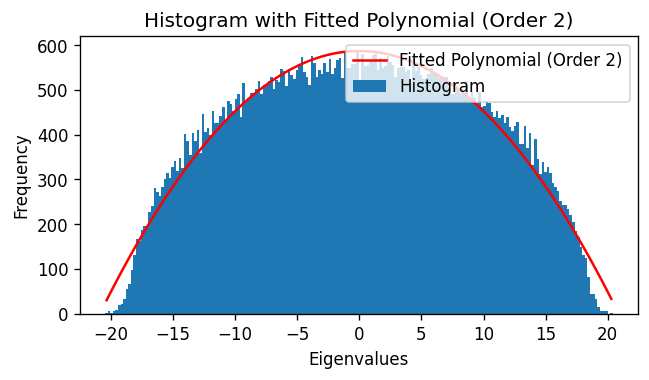

In [64]:
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Generate some sample data (replace this with your own data)
data = np.random.normal(0, 1, 10000)  # Example: 1000 normally distributed random numbers
data = results

# Step 2: Create a histogram
hist, bin_edges = np.histogram(data, bins=200)  # You can adjust the number of bins

# Calculate bin centers for x values
bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2

# Step 3: Fit a polynomial function (polynomial of order k) to the histogram data
k = 2  # Replace with your desired polynomial order
coefficients = np.polyfit(bin_centers, hist, k)

# Create a polynomial function based on the coefficients
fitted_poly = np.poly1d(coefficients)

# Step 4: Plot the histogram and the fitted polynomial
plt.figure(figsize=(6,3), dpi=120)
plt.bar(bin_centers, hist, width=bin_edges[1] - bin_edges[0], align='center', label='Histogram')
#plt.hist(data, bins=200)
x_range = np.linspace(min(bin_centers), max(bin_centers), 100)  # Generate x values for the fitted polynomial
plt.plot(x_range, fitted_poly(x_range), 'r-', label=f'Fitted Polynomial (Order {k})')
plt.xlabel('Eigenvalues')
plt.ylabel('Frequency')
plt.legend()
plt.title(f'Histogram with Fitted Polynomial (Order {k})')
plt.show()


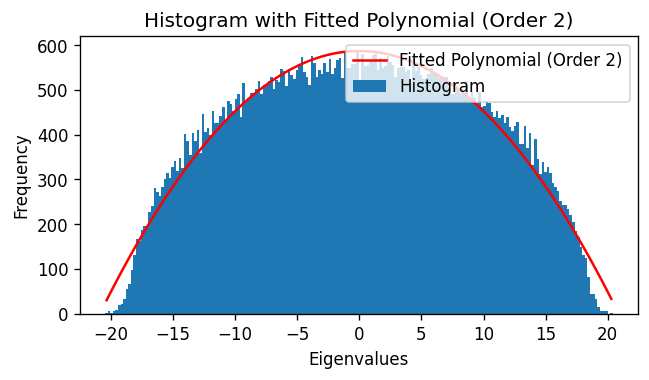

In [65]:
data = results

# Create a histogram
hist, bin_edges = np.histogram(data, bins=200)  # You can adjust the number of bins

# Calculate bin centers for x values
bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2

# Fit a polynomial of order k to the histogram data
coefficients2 = np.polyfit(bin_centers, hist, 2)
coefficients3 = np.polyfit(bin_centers, hist, 2)
coefficients4 = np.polyfit(bin_centers, hist, 2)
coefficients5 = np.polyfit(bin_centers, hist, 2)

# Create a polynomial function based on the coefficients
fitted_poly = np.poly1d(coefficients)

# Plotting
plt.figure(figsize=(6,3), dpi=120)
plt.bar(bin_centers, hist, width=bin_edges[1] - bin_edges[0], align='center', label='Histogram')
x_range = np.linspace(min(bin_centers), max(bin_centers), 100)  # Generate x values for the fitted polynomial
plt.plot(x_range, fitted_poly(x_range), 'r-', label=f'Fitted Polynomial (Order {k})')
plt.xlabel('Eigenvalues')
plt.ylabel('Frequency')
plt.legend()
plt.title(f'Histogram with Fitted Polynomial (Order {k})')
plt.show()


## paralelize

In [16]:
import multiprocessing

In [17]:
num_cores = multiprocessing.cpu_count()
print(f"Number of CPU cores available: {num_cores}")

Number of CPU cores available: 16


In [ ]:
if __name__ == "__main__":
    # Number of parallel processes
    num_processes = 4  # You can adjust this to your hardware capabilities
    num_of_experiments = 10
    num_of_dims_of_mtx = 8

    # Create a multiprocessing pool
    pool = multiprocessing.Pool(processes=num_processes)

    # Define the arguments for each run of function 'experiment()'
    a_values = [None] * num_of_experiments  # names of experiments
    b_values = [num_of_dims_of_mtx] * num_of_experiments  # dimensions of matrices
    c_values = [False] * num_of_experiments  # printing suppresed
    d_values = [13] * num_of_experiments  # Example values for 'c'\
    d_values = list(range(1, num_of_experiments+1)) # random seeds (otherwise each thread gives deterministic results)

    # Create a list of argument tuples for foo
    # args for 'experiment' func >>> (name:str = 'none', num_of_dims_of_mtx: int = 3, print_result: bool = False)
    arguments = [(name, num_of_dims_of_mtx, print_result, seed) for name, num_of_dims_of_mtx, print_result, seed in zip(a_values, b_values, c_values, d_values)]

    # Use Pool.starmap to run foo in parallel
    results = pool.starmap(experiment, arguments)

    # Close the pool (no more tasks can be added)
    pool.close()

    # Wait for all processes to complete
    pool.join()

    # 'results' will contain the results of running foo for each set of arguments
    #print(results)


In [ ]:
len(results)

In [ ]:
# concatenate values from all pools into one list
results_par = [item for sublist in results for item in sublist]

In [ ]:
plt.figure(figsize=(6,3), dpi=120)
sbn.histplot(results_par, kde=True)

plt.xlabel('eigenvalues')
plt.savefig('test_img.png', dpi=300)

plt.show()

In [ ]:
# is it normal distribution?
from scipy.stats import shapiro
import random

# Generate some example data (replace this with your actual data)
data = [random.normalvariate(0, 1) for _ in range(100)]
data = results_par

# Perform the Shapiro-Wilk test
statistic, p_value = shapiro(data)

# Set a significance level (e.g., 0.05)
alpha = 0.05

# Check if the p-value is less than the significance level
if p_value > alpha:
    print("Data looks like it comes from a normal distribution (fail to reject H0)")
else:
    print("Data does not look like it comes from a normal distribution (reject H0)")


## END

## saving and loading python objects

### save>>

In [ ]:
import pickle

# Your list data
my_list = [1, 2, 3, 4, 5]

# Specify the file name where you want to save the list
file_name = "my_list.pkl"

# Open the file in binary write mode and save the list using pickle
with open(file_name, "wb") as file:
    pickle.dump(my_list, file)

del(my_list)

### load>>

In [ ]:
import pickle

# Specify the file name from which to load the list
file_name = "my_list.pkl"

# Open the file in binary read mode and load the list using pickle
with open(file_name, "rb") as file:
    loaded_list = pickle.load(file)

# Now, loaded_list contains the data from the saved list
print(loaded_list)


## paralel computing

In [30]:
import multiprocessing

# Define your function
def foo(a, b, c):
    # Your function logic here
    result = a + b + c
    return result

if __name__ == "__main__":
    # Number of parallel processes
    num_processes = 4  # You can adjust this to your hardware capabilities

    # Create a multiprocessing pool
    pool = multiprocessing.Pool(processes=num_processes)

    # Define the arguments for foo function
    a_values = [1, 2, 3, 4, 5]  # Example values for 'a'
    b_values = [10, 20, 30, 40, 50]  # Example values for 'b'
    c_values = [100, 200, 300, 400, 500]  # Example values for 'c'

    # Create a list of argument tuples for foo
    arguments = [(a, b, c) for a, b, c in zip(a_values, b_values, c_values)]

    # Use Pool.starmap to run foo in parallel
    results = pool.starmap(foo, arguments)

    # Close the pool (no more tasks can be added)
    pool.close()

    # Wait for all processes to complete
    pool.join()

    # 'results' will contain the results of running foo for each set of arguments
    print(results)


[111, 222, 333, 444, 555]
